# Sentence Generation on Quantum Computers (Quantum Natural Language Generation)

This notebook is an implementation of the paper "Quantum Natural Language Generation on Near-Term devices":https://arxiv.org/pdf/2211.00727.pdf. 

*Meaning Classification with lambeq QNLP Toolkit**

Quantum Pipeline Simulation

The first part of this notebook is based on the following example from Lambeq, a python library specifically created for QNLP tasks: https://cqcl.github.io/lambeq/examples/quantum_pipeline.html.

### Installing required dependencies

In [1]:
#uncomment to install dependencies
#! pip install lambeq
#! pip install pytket-qiskit
#! pip install nltk

import numpy as np
import warnings
import os
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Step 1: Read in the data and create diagrams

To begin with, we are going to read in the 130 sentences stored in the dataset directory. Each senetence has been assigned As is standard in machine learning, these sentences are split into training, validation (dev), and development datasets.


In [2]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('datasets/mm_mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mm_mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mm_mc_test_data.txt')

## Step 2: Parsing and Diagram creation

We now want to turn each sentence in the dataset into a parameterised quantum circuit which encodes it's meaning. We begin doing this by parsing the sentences and generating their corresponding DisCoCat diagrams.

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


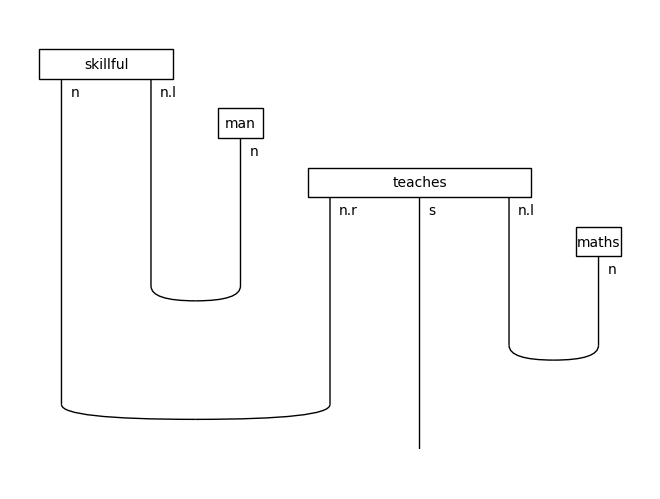

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


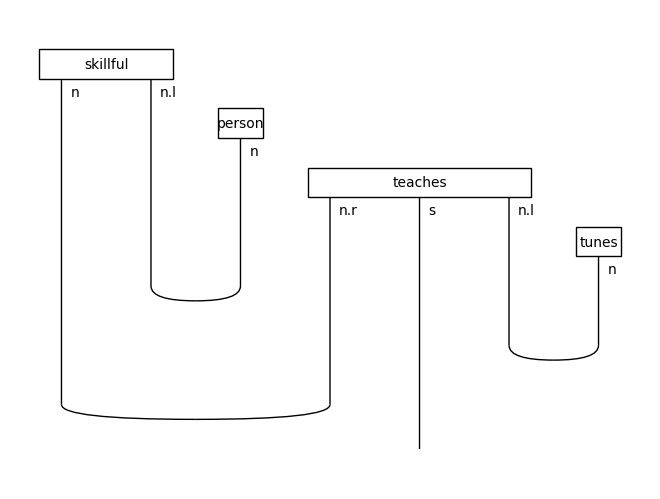

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


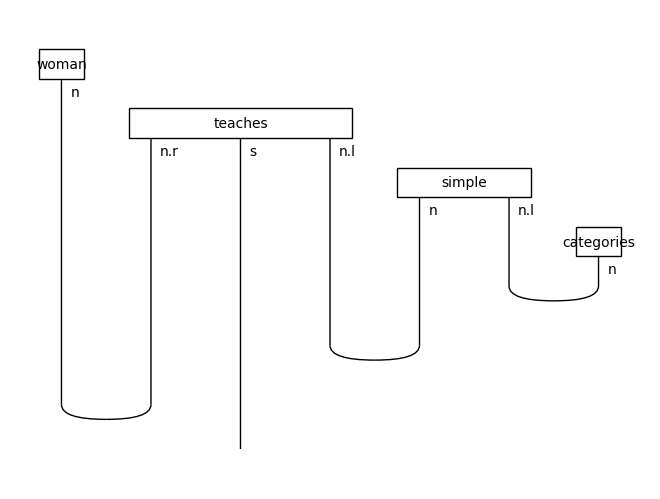

In [3]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data)
raw_train_diagrams[0].draw()
raw_dev_diagrams = parser.sentences2diagrams(dev_data)
raw_dev_diagrams[0].draw()
raw_test_diagrams = parser.sentences2diagrams(test_data)
raw_test_diagrams[0].draw()



## Step 3: Diagram Rewriting

Now it's time for the optional diagram rewriting step. We are going to remove all the cups in the diagram . This is a helpful rewrite since it means that the quantum circuits we eventually end up with in the end can be implemented with less qubits, hence faster execution

Before removing cups


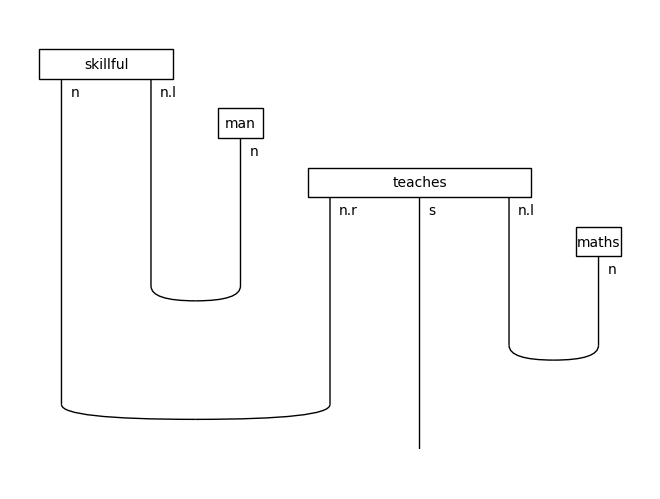

After removing cups


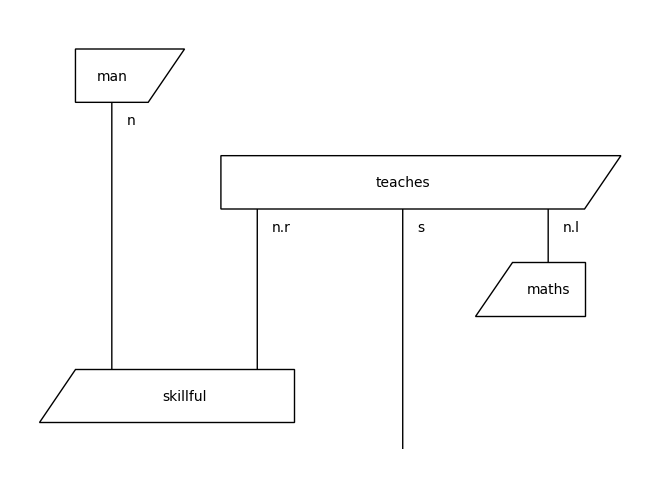

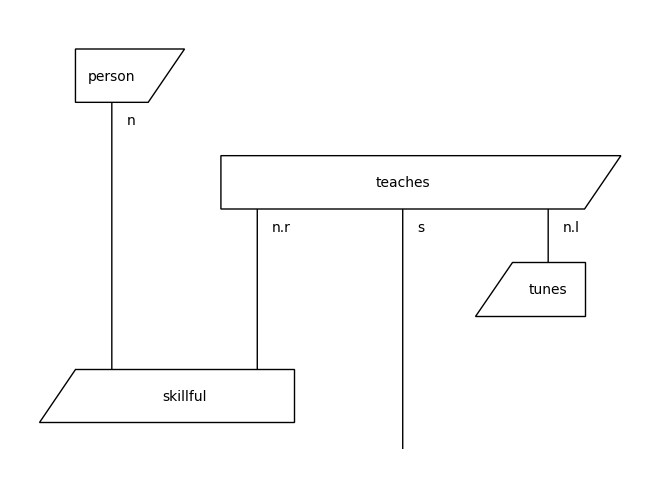

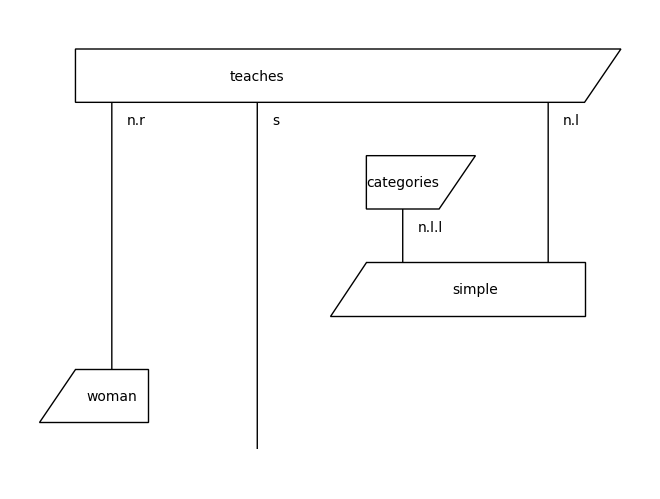

In [4]:
from lambeq import remove_cups

print("Before removing cups")
raw_train_diagrams[0].draw()
train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
print("After removing cups")
train_diagrams[0].draw()

dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
dev_diagrams[0].draw()

test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]
test_diagrams[0].draw()




## Step 4: Create Parameterised Quantum Circuit 

We are finally ready to create our parameterised quantum circuit. In order to do this we will use lambeqs IQPAnsatz (See https://cqcl.github.io/lambeq/tutorials/parameterise.html for more info). 

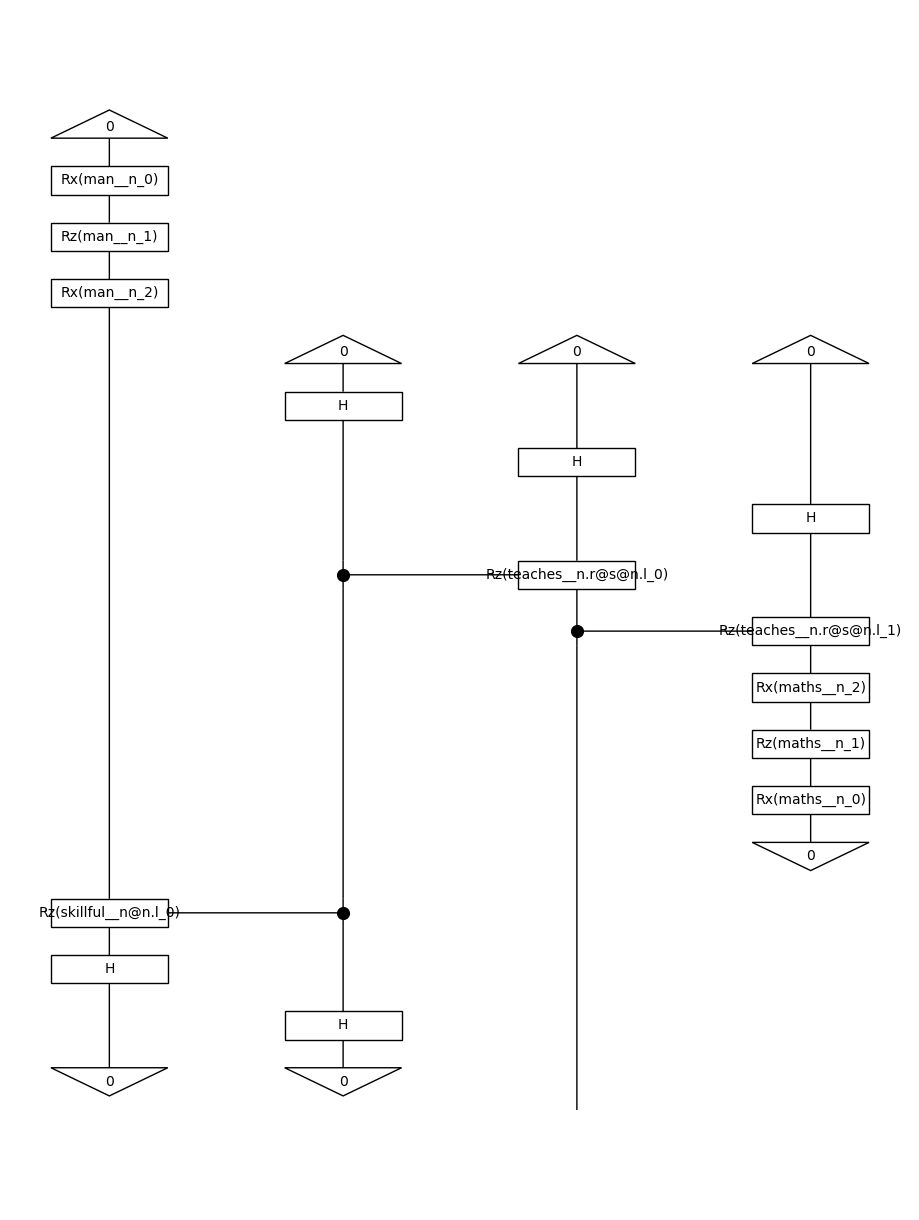

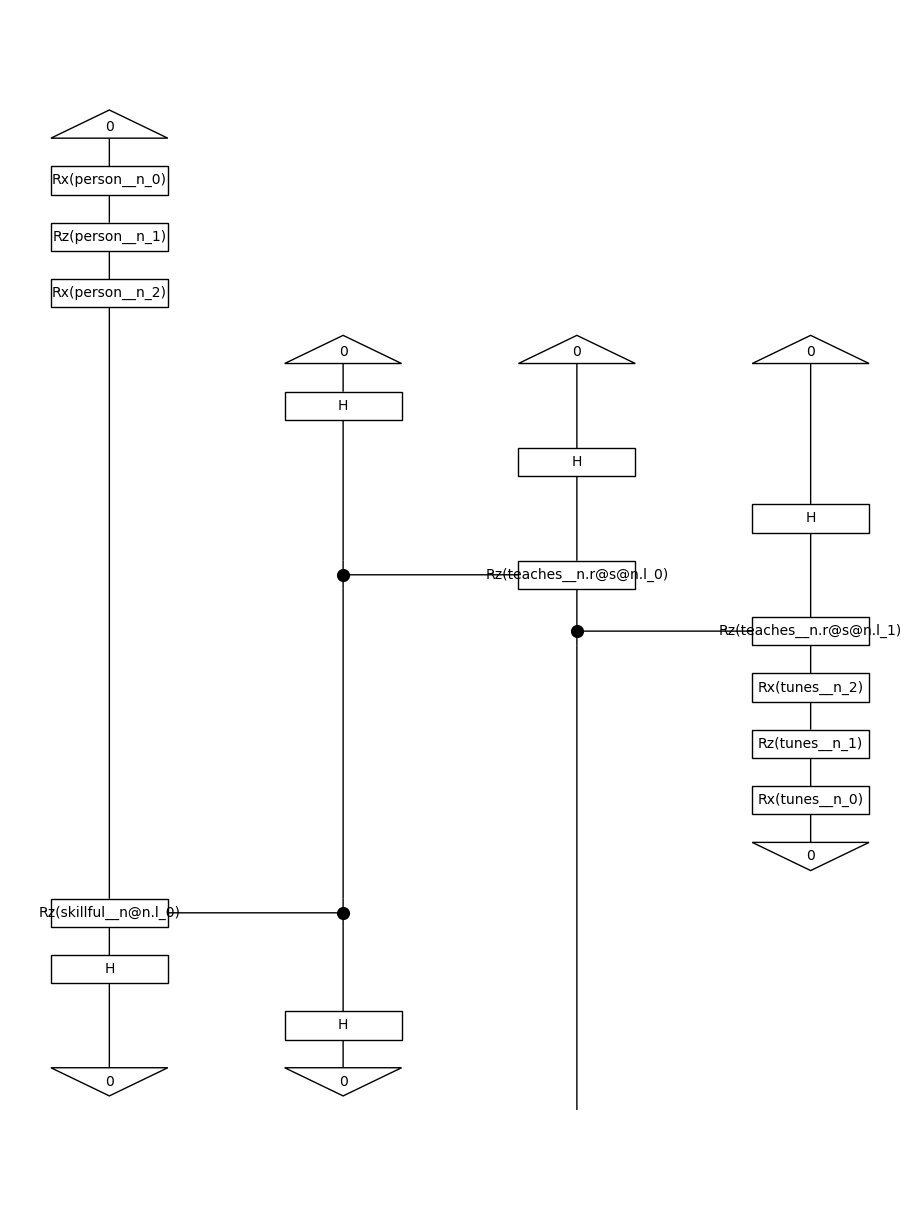

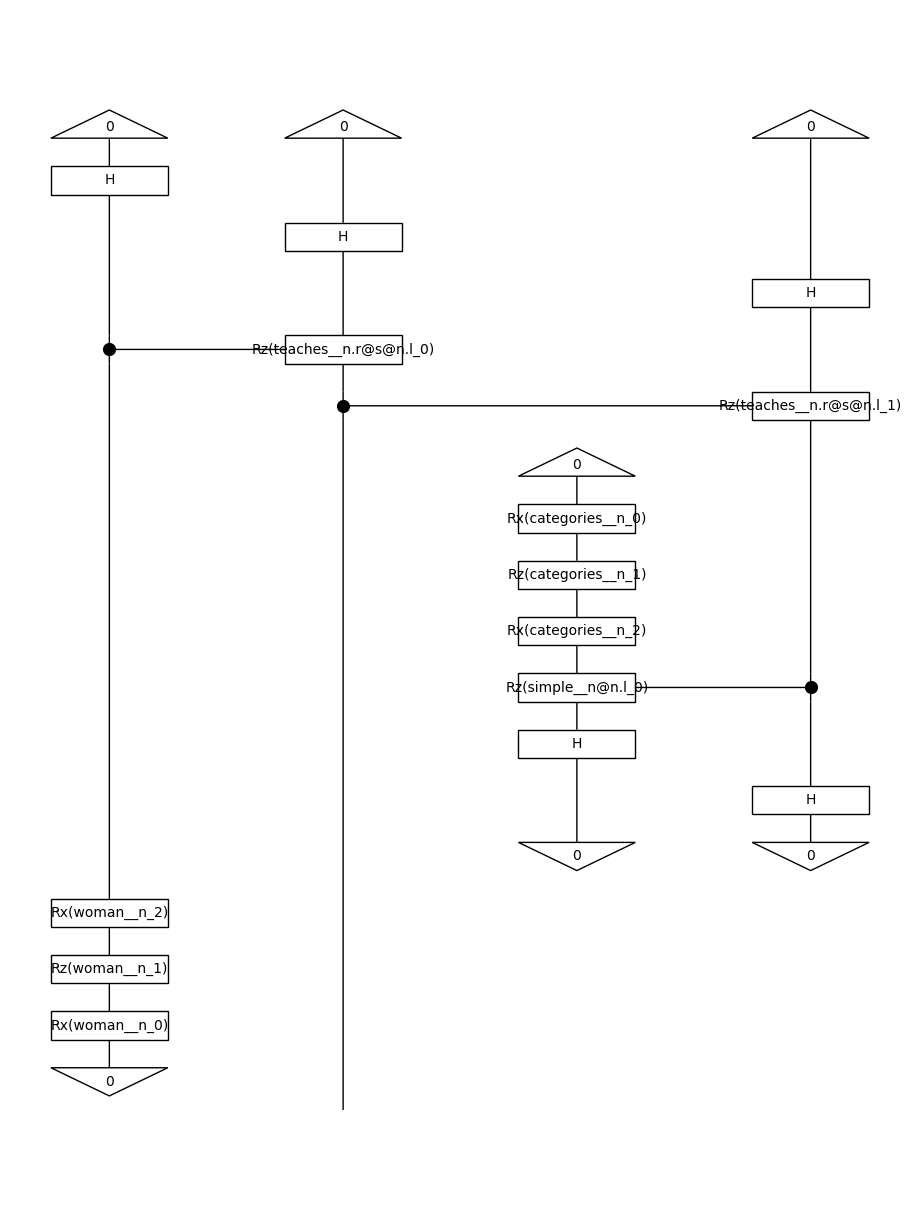

In [5]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
train_circuits[0].draw(figsize=(9, 12)) #drawing one of the circuits
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
dev_circuits[0].draw(figsize=(9, 12))
test_circuits = [ansatz(diagram) for diagram in test_diagrams]
test_circuits[0].draw(figsize=(9, 12))

### Running circuits on a backend
Now we choose a backend on which our quantum circuits is going to be run. For simplicity  and fast execution we will use the AerBackend simulator provided by IBMQ

In [6]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits+dev_circuits+test_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

# Step 6: Creating the quantum sentence classifier. 

The code below trains our quantum sentence classifier. Note that, the training of this classifier can approximately 45 minutes

In [7]:
model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

from lambeq import QuantumTrainer, SPSAOptimizer

EPOCHS = 30
BATCH_SIZE = 30

trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)
trainer.fit(train_dataset, val_dataset, logging_step=1)

Epoch 1:   train/loss: 0.7303   valid/loss: 0.6414   train/acc: 0.6143   valid/acc: 0.6333
Epoch 2:   train/loss: 1.0185   valid/loss: 0.7817   train/acc: 0.6357   valid/acc: 0.6000
Epoch 3:   train/loss: 0.8948   valid/loss: 0.9060   train/acc: 0.4143   valid/acc: 0.5000
Epoch 4:   train/loss: 1.2967   valid/loss: 0.9755   train/acc: 0.5429   valid/acc: 0.4667
Epoch 5:   train/loss: 0.8128   valid/loss: 0.7287   train/acc: 0.5786   valid/acc: 0.5333
Epoch 6:   train/loss: 0.6777   valid/loss: 0.6570   train/acc: 0.6714   valid/acc: 0.6000
Epoch 7:   train/loss: 0.5697   valid/loss: 0.6337   train/acc: 0.6214   valid/acc: 0.6333
Epoch 8:   train/loss: 0.5580   valid/loss: 0.5643   train/acc: 0.7571   valid/acc: 0.7000
Epoch 9:   train/loss: 0.5211   valid/loss: 0.5117   train/acc: 0.7857   valid/acc: 0.7167
Epoch 10:  train/loss: 0.4904   valid/loss: 0.4978   train/acc: 0.7786   valid/acc: 0.7667
Epoch 11:  train/loss: 0.5110   valid/loss: 0.5143   train/acc: 0.7357   valid/acc: 0.7000

# sentence generation!


We are now ready to implement an algorithm that generates a sentence about cooking. This will be achieved by searching through the space of all possible sentences in order to find and output a sentence about cooking. 

The task above is called an optimisation problem. There are many different search strategies that can be employed to solve this task. Here we will employ the simplest possible strategy: Random guessing. 

Before we implement the random guessing algorithm we describe two helper functions. The details of how these are implemented are not important, but their input output behaviour is:

1. The `_create_sentence_search_space()` function takes in no inputs and returns a list of all the sentences in our search space. 
2. The `_measure_quantum_circuit_for_sentence(sentence)` function takes in a sentence in the search space and measures the corresponding paraemterised quantum circuit, returning an array of two numbers between 0 and 1, which add up to 1. The first number represents the probability that the given sentence is about food, while the second number represents the probability that it is about IT.

In [38]:
from nltk import CFG
from nltk.parse.generate import generate

def _create_sentence_search_space():
    MC_GRAMMAR = """
      S -> NP VP
      NP -> N
      VP -> V NP
      NP -> A N
      A -> 'skillful' | 'tasty' | 'useful'
      N -> 'application' | 'dinner' | 'man' | 'meal' | 'person' | 'program' | 'sauce' | 'software' | 'woman'
      V -> 'bakes' | 'cooks' | 'debugs' | 'prepares' | 'runs'
      """

    VOCAB = ['debugs', 'dinner', 'person', 'useful', 'runs', 'program', 'bakes', 'cooks', 'skillful', 'woman', 'prepares', 'application', 'man', 'software', 'sauce', 'meal', 'tasty']

    subjects = ["man", "woman", "person"]
    objects = ["sauce", "meal", "application", "software", "dinner", "program"]

    GRAMMAR = CFG.fromstring(MC_GRAMMAR)
    SENTENCES = list(generate(GRAMMAR))
    #print(SENTENCES)

    def filter_sentence(sentence):
        # Make sure no word appears more than once:
        if not len(set(sentence)) == len(sentence):
            return False

        # Make sure subject appears before object:
        try:
            subject_position = next(i for i,v in enumerate(sentence) if v in subjects)
            object_position = next(i for i,v in enumerate(sentence) if v in objects)
        except:
            return False
        return subject_position < object_position

    SENTENCES = list(filter(filter_sentence, SENTENCES))
    return SENTENCES

def _measure_quantum_circuit_for_sentence(sentence):
    parser = BobcatParser(verbose='text')
    diagram = parser.sentences2diagrams([sentence])
    circ = [ansatz(d) for d in diagram]

    return model.get_diagram_output(circ)[0]

In [39]:
#_create_sentence_search_space()
model = TketModel.from_checkpoint('datasets/checkpoint.pickle', backend_config=backend_config)

In [40]:
import random
SENTENCES = _create_sentence_search_space()

def randomly_generate_sentence_with_topic(topic):
    i = 0
    while i < 100:
        i += 1
        print(i)
        sentence = " ".join(random.choice(SENTENCES))
        print(sentence)
        prediction = _measure_quantum_circuit_for_sentence(sentence)
        print(prediction)
        if topic == "Food" and prediction[0] > 0.9:
            return i, sentence
            break
        elif topic == "IT" and prediction[1] > 0.9:
            return i, sentence
            break
    return 100, "Max iterations reached"

Let's now run the function to generate a sentence about food

In [45]:
#Uncomment to generate sentence
#randomly_generate_sentence_with_topic("Food")

### Observation
From the above, you can see that a sentence is randomly generated. However, Of course, random guessing is not the most efficient way of navigating through the search space of sentences! There has to be a better way

# Introducing Simulated Annealing Algorithm

A metaheuristic to approximate global optimization in a large search space for an optimization problem. It is often used when the search space is discrete (for example the traveling salesman problem, the boolean satisfiability problem, protein structure prediction, and job-shop scheduling). For problems where finding an approximate global optimum is more important than finding a precise local optimum in a fixed amount of time, simulated annealing may be preferable to exact algorithms such as gradient descent or branch and bound. More about simulated Annealing algorithm via : https://en.wikipedia.org/wiki/Simulated_annealing

This method was based on the well known hill climbing algorithm: https://en.wikipedia.org/wiki/Hill_climbing

In [ ]:
import random
from math import exp

elements = 
def objective(sentence, topic):
    try:
        prediction = _measure_quantum_circuit_for_topic(composition)
    except:
        return 0

    if topic == "Food":
        return prediction[0]
    elif topic == "IT":
        return prediction[1]




def SA_generate_sentences(topic):
    checkpoints = []
#### simulated annealing algorithm

    # generate an initial point
    current_state = random.choice(SENTENCES)
    print("initial_sentence: {}".format(current_state))
    # evaluate the initial point
    curr_eval = objective(current_state, topic)
    print("initial_eval: {}".format(curr_eval))
    if objective(current_state, topic) > 0.98:
        return 1, current_state, [current_state]

    temp = 5
    i = 0
    # run the algorithm
    while i < 500:
        checkpoints.append(curr)
        i += 1
        candidate = []
        print("current_state: {}".format(current_state))
        while candidate not in SENTENCES:
            candidate = current_state.copy()
            # Randomly decide on an operation: 0 = DELETE, 1 = Replace, 2 = INSERT
            if len(candidate) == 1:
                op = random.randint(1, 2)
            elif len(candidate) < 6:
                op = random.randint(0, 2)
            else:
                op = random.randint(0, 1)
            if op == 0:
                # Remove random word
                word = random.choice(candidate)
                candidate.remove(word)
            if op == 1:
                new_word = random.choice(elements)
                index = random.randint(0,len(candidate) - 1)
                candidate[index] = new_word
            if op == 2:
                # Add random word at random position
                new_word = random.choice(elements)
                candidate.insert(random.randint(0,len(candidate)),new_word)

        print("new candidate: {}".format(candidate))
        candidate_eval = objective(candidate, topic)
        print("candidate_eval: {}".format(candidate_eval))
        # check winning criteria
        if candidate_eval > 0.98:
            return i, candidate, checkpoints
        # difference between candidate and current point evaluation
        diff = candidate_eval - curr_eval
        # calculate temperature for current epoch
        t = temp / float(i + 1)
        # calculate metropolis acceptance criterion
        metropolis = exp(diff / t)
        # check if we should keep the new point
        random_float = random.uniform(0,1)
        if diff > 0 or (random.uniform(0, 1) < metropolis):
        # store the new current point
            print("Switch")
            curr, curr_eval = candidate, candidate_eval
        else: 
            print("No switch")
        print("End of iteration: {}".format(i))
    return 500, "Max iterations reached", checkpoints